# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
dataset = pd.read_json(r'C:\Users\Luigi\Documents\DS - Proyectos\dataset_amazon\dataset_es_dev.json',lines=True)
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [4]:
dataset.shape

(5000, 8)

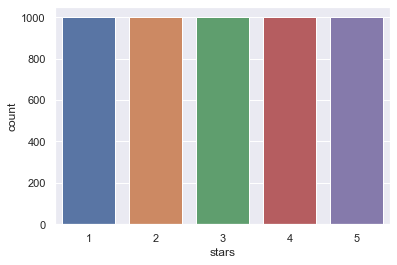

In [5]:
sns.countplot(data = dataset , x='stars')
plt.show()

In [6]:
#index_random = np.random.randint(1,4000)
#titular = dataset.review_body.iloc[index_random]
#print(index_random, titular)
#print(index_random, dataset.stars.iloc[index_random])

In [7]:
dataset = dataset.iloc[:,[4,5,3]]
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

,review_body,review_title,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,1
1,No he recibido el pedido no la devolución,No lo he recibido,1
2,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,1
3,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,1
4,No me gusta su olor a viejo y aspecto malo,No me gusta,1


In [8]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
#stopwords

In [32]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import SnowballStemmer
# spanish_stemmer = SnowballStemmer('spanish')
# (spanish_stemmer.stem("texto_en_str"))
#from nltk.stem import PorterStemmer
#stemmer = PorterStemmer()


In [33]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list=[]
for review in dataset.review_body:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    #review=re.sub("[^a-zA-Z]"," ",str(review))#borra los espacios y las tiles
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)
    # Eliminamos las palabras de menos de 3 letras
    #titular = [palabra for palabra in titular if len(palabra)>2]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[stemmer.stem(palabra) for palabra in review]
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    
    # Vamos armando una lista con todos los titulares
    review_list.append(review)
    #dataset["titular_normalizado"] = titular_list

In [34]:
review_list

['malisimo , grand demasiado aparatoso mal protector pantalla',
 'recibido pedido devolución',
 'buscar sistema , funciona bien . abrazadera lleva agarrar manillar aprieta bien , deslizando linterna hacia abajo .',
 'utilicé broca menor diámetro doblaron varia si mantequilla , hacer mínima presión . vez doblada , intentar enderezarla , parten . exteriorment amarilla interior fundido gri . peor compra hecho bastant tiempo .',
 'gusta olor viejo aspecto malo',
 'hola , despué recog paquet llegado bola rota .',
 'part poder elegir color , envian cesto color asa , imagino aprovechando van rompiendo , dicen color aleatorio , foto , cesta asa mismo color . recomiendo comprarlo pueda elegir color . único alivio , romperá pronto , calidad allá .',
 'baja calidad ahí si precio . compra supon tirar dinero',
 'producto sale entregado recibido .',
 'recomiendo , pega acaba despegandos',
 'desliza hacia abajo rato , hecho materi baja calidad . recomiendo',
 'do mese despué , llegado , amazon debe c

In [35]:
freq = nltk.FreqDist(review_list)
freq

FreqDist({'buena relación calidad precio': 7, 'llegado producto': 2, 'cumpl expectativa': 2, 'bien calidad precio': 2, 'buena relación calidad-precio': 2, 'justo buscaba': 2, 'buena calidad .': 2, 'buen producto precio': 2, 'malisimo , grand demasiado aparatoso mal protector pantalla': 1, 'recibido pedido devolución': 1, ...})

In [36]:
dataset["review_stem"] = review_list
dataset.tail()

,review_body,review_title,stars,review_stem
4995,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,5,encantado cesta . llegado impecable.tien tamañ...
4996,Desempeña su función correctamente,calidad precio,5,desempeña función correctament
4997,Me ha encantado la diadema! Las flores son tal...,Excelente,5,encantado diadema ! flore tal vienen imagen ve...
4998,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,5,"gustan funda tpu , funda normalment fina color..."
4999,El artículo ha cumplido con las expectativas q...,Buena calidad,5,artículo cumplido expectativa deseaba .


In [38]:
## Para probar con Stemmizer:
list_titulos = list(dataset_stem'dataset'].values)
is_sarc = dataset_stem['is_sarcastic'].values


SyntaxError: invalid syntax (<ipython-input-38-5bc2b23eb5a5>, line 2)